# HomeTap : Demonstration Project 
## Thomas Brewer

*Note*: This is a simple project in preparation for my interview with HomeTap.  The purpose is not to show a complex analysis, but rather demonstrate some of the skills .up my sleeve (and asked for in the job listing), and emphasize my motivation for this position.
<br>
<br>
You will also find the same on my github : https://github.com/t-brewer/hometap

### Objective :  Make simple model to estimate house prices based on features.

For this I use the San Luis Obipso houses dataset (https://wiki.csc.calpoly.edu/datasets/wiki/Houses). 
I would have used some from the Boston area, but I was having trouble finding a free dataset, beyond the *Boston Housing Dataset* typically used in intro to machine learning courses.

The dataset used has some very basic properties :

 - **MLS**: Multiple listing service number for the house (unique ID).
 - **Location**: city/town where the house is located. Most locations are in San Luis Obispo county and northern Santa Barbara county (Santa Maria-Orcutt, Lompoc, Guadelupe, Los Alamos), but there some out of area locations as well.
 - **Price**: the most recent listing price of the house (in dollars).
 - **Bedrooms**: number of bedrooms.
 - **Bathrooms**: number of bathrooms.
 - **Size**: size of the house in square feet.
 - **Price/SQ.ft**: price of the house per square foot.
 - **Status**: type of sale. Thee types are represented in the dataset: Short Sale, Foreclosure and Regular.
 <br>
 <br>

This preparation should demonstrate: 
- Data Manipulation (via pandas)
- Exploratory Data Analysis / Statistics
- Visualizations
- Sci-Kit Learn
- Machine Learning 
- Web scraping (not asked for, but thought I would include it anyway since it could be a useful skill when dealing with real estate (get some extra info about basically anything))


In [1]:
# Import libraries
# Basic Libraries
import pandas as pd
import numpy as np

# Web Scraping Libraries
import requests
from bs4 import BeautifulSoup

# SKLearn libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Plotting Libraries
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Importing / Retrieving Data

As stated above, the basic data comes from a csv file downloaded from the mentioned website.  The data is not complex, which makes it a good tool easily demonstrate various skills.

In [2]:
# Import data (downloaded csv), and sort by location
data = pd.read_csv('RealEstate.csv')
data.sort_values(by='Location')
data.head()

,MLS,Location,Price,Bedrooms,Bathrooms,Size,Price/SQ.Ft,Status
0,132842,Arroyo Grande,795000.0,3,3,2371,335.30,Short Sale
1,134364,Paso Robles,399000.0,4,3,2818,141.59,Short Sale
2,135141,Paso Robles,545000.0,4,3,3032,179.75,Short Sale
3,135712,Morro Bay,909000.0,4,4,3540,256.78,Short Sale
4,136282,Santa Maria-Orcutt,109900.0,3,1,1249,87.99,Short Sale


When looking at the unique location names, I noticed some names had extra spaces.  This needs to be fixed so that we may encode it properly later on.  

In [4]:
data.Location = data.Location.apply(lambda x : x.strip())

### Fetching Population Densities

To demonstrate web scrapingFor each city listed in the data set, I would like to fetch the population density off of wikipedia.  Now I know that wikipedia has its own API and python library, but it is very unlikely that I will be querying wikipedia for this position, so I decided to use Beautiful soup, and get the data myself.
<br>
<br>
To do the scraping we are going to need the URLs of each city.  Thankfully wikipedia has a consitent way of providing them, so we can define the URL prefix and suffix, and to this over a loop.  Note that these values will be the same for each unique city, so I will be storing the results in a separate dataframe (for now at least).  Also, note that some of these pages do not include the population density (for small communities), so I will just be leaving null values there.   

In [5]:
# FETCHING POPULATION DENSITIES

# define dictionary to store results :
density_data = []

# Define URL prefix/suffix
url_prefix = 'https://en.wikipedia.org/wiki/'
url_suffix = ',_California'

# Define unique cities : 
cities = data.Location.unique()

# Loop over unique cities to fetch population densities
for c in cities:
    
    # define URL (and add underscore to two word city names for URL)
    url = url_prefix + c.replace(' ', '_') + url_suffix
    
    # Request query
    res = requests.get(url)
    
    # If this is a valid URL, we extract the density, otherwise we move on the next one in the list
    if (res.status_code == 200):
        # Valid URL
  
        # Put url content(html) into beautiful soup object
        soup = BeautifulSoup(res.content, 'lxml')
   
        # Get infobox table, extract row with 'Density' in the text, and get a float value of
        # the population density (per square mile)
        # Note that not all tables include the population density, so we will just have to live with null values
        try:
            table   = soup.find('table', {'class':'infobox geography vcard'})
            row     = [tr for tr in table.find_all('tr') if 'Density' in tr.text][0]
            density = float(row.td.text.split('/')[0].replace(',', ''))
            
        except : 
            density = np.nan
        
        density_data.append([c, density])
    
    else:
        continue

In [6]:
# Convert list of population densities to a pandas dataframe
density_data = pd.DataFrame(density_data, columns=['Location', 'pop_density'])
density_data.head()

,Location,pop_density
0,Arroyo Grande,3102.52
1,Paso Robles,1640.97
2,Morro Bay,2007.92
3,Oceano,4700.00
4,Atascadero,1162.74


## Preprocessing / Cleaning

Now that we have all the data that we will be using, let us take a closer look at the main set, and see if there is any cleaning that needs to be done. 

In [7]:
# Check for null values. 
data.isnull().sum()

MLS            0
Location       0
Price          0
Bedrooms       0
Bathrooms      0
Size           0
Price/SQ.Ft    0
Status         0
dtype: int64

No null values, so nothing to do on that end. 

In [8]:
# Check that data types make sense : 
data.dtypes

MLS              int64
Location        object
Price          float64
Bedrooms         int64
Bathrooms        int64
Size             int64
Price/SQ.Ft    float64
Status          object
dtype: object

Everything seems good here as well. 
<br>
<br>
Now, this data set does not very many columns, so we can check each value range and make sure that those make sense. 

In [9]:
data.describe().loc[['min', 'max']]

,MLS,Price,Bedrooms,Bathrooms,Size,Price/SQ.Ft
min,132842.0,26500.0,0.0,1.0,120.0,19.33
max,154580.0,5499000.0,10.0,11.0,6800.0,1144.64


No negative values, that is a good start.  There are some houses that have zero bedrooms, which is a bit odd. Perhaps this just means studio appartments, so I will assume it not an error. Also, 120 square feet is really small.  But I suppose it is possible. 
<br>
<br>
There doesn't seem to be any obvious cleaning to be done, so we leave it at that (perhaps something will show up later on).

### Encoding Status 
Since the "Status" column is a string, we need to encode it, and make everything numerical. 

In [10]:
data = pd.get_dummies(data, prefix=None, columns=['Status'])
data.head()

,MLS,Location,Price,Bedrooms,Bathrooms,Size,Price/SQ.Ft,Status_Foreclosure,Status_Regular,Status_Short Sale
0,132842,Arroyo Grande,795000.0,3,3,2371,335.30,0,0,1
1,134364,Paso Robles,399000.0,4,3,2818,141.59,0,0,1
2,135141,Paso Robles,545000.0,4,3,3032,179.75,0,0,1
3,135712,Morro Bay,909000.0,4,4,3540,256.78,0,0,1
4,136282,Santa Maria-Orcutt,109900.0,3,1,1249,87.99,0,0,1


## Exploratory Data Analysis. 
To get a feel for the data we will be making a few plots, looking at some stats, correlations, etc... Nothing too extensive though since this is a demonstration. 

### General Statistics : 
Mostly as reference, let us see what the overview of the data looks like : 

In [11]:
data.describe()

,MLS,Price,Bedrooms,Bathrooms,Size,Price/SQ.Ft,Status_Foreclosure,Status_Regular,Status_Short Sale
count,781.000000,7.810000e+02,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000
mean,151224.550576,3.833291e+05,3.142125,2.355954,1755.058899,213.131293,0.207426,0.131882,0.660691
std,3936.122042,3.490381e+05,0.855768,0.846596,819.577603,115.082146,0.405723,0.338579,0.473778
min,132842.000000,2.650000e+04,0.000000,1.000000,120.000000,19.330000,0.000000,0.000000,0.000000
25%,149922.000000,1.990000e+05,3.000000,2.000000,1218.000000,142.140000,0.000000,0.000000,0.000000
50%,152581.000000,2.950000e+05,3.000000,2.000000,1550.000000,188.360000,0.000000,0.000000,1.000000
75%,154167.000000,4.290000e+05,4.000000,3.000000,2032.000000,245.420000,0.000000,0.000000,1.000000
max,154580.000000,5.499000e+06,10.000000,11.000000,6800.000000,1144.640000,1.000000,1.000000,1.000000


### Correlations : 
We now look at the correlation matrix of these different features.  For this, I am using a function that I made a while back to show everything nicely, with the option of filtering out correlations out of a certain range. Here is the function in question : 

In [12]:
def corr_map(data, figsize=(15,10), mask_val = None):
    # Make correlation heat map from pandas dataframe
    # pass a value to mask_val to only see correlations
    # above a certain value (the absolute value of the correlation)
    corr = data.corr()    
    
    # Make mask to only show bottom triangle
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(corr)] = True
    
    # Add to the mask (if mask_val passed)
    if (mask_val != None):
        mask[abs(corr) < mask_val] = True
    
    # Make heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2g')
    pass


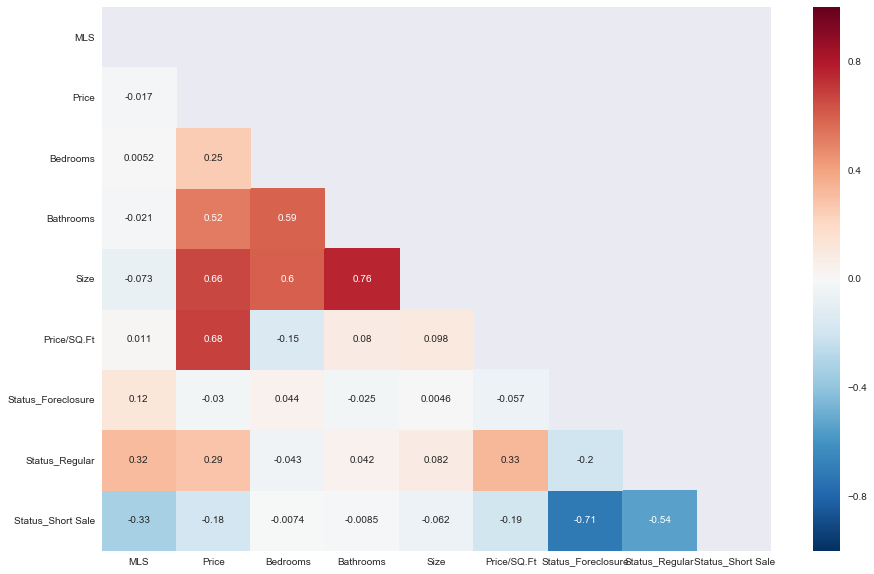

In [13]:
# Correlation heat map
corr_map(data)

Since in the end house prices are what we are interested in, let us focus on that.  We see that it is most correlated with `Size`and `Bathrooms`.  Surprisingly, there is little correlation with the number of bedrooms.  We can take a closer look at some of these by plotting the Price as a function of the different features (excluding the binary features), and price / sq foot since it is redundant. 

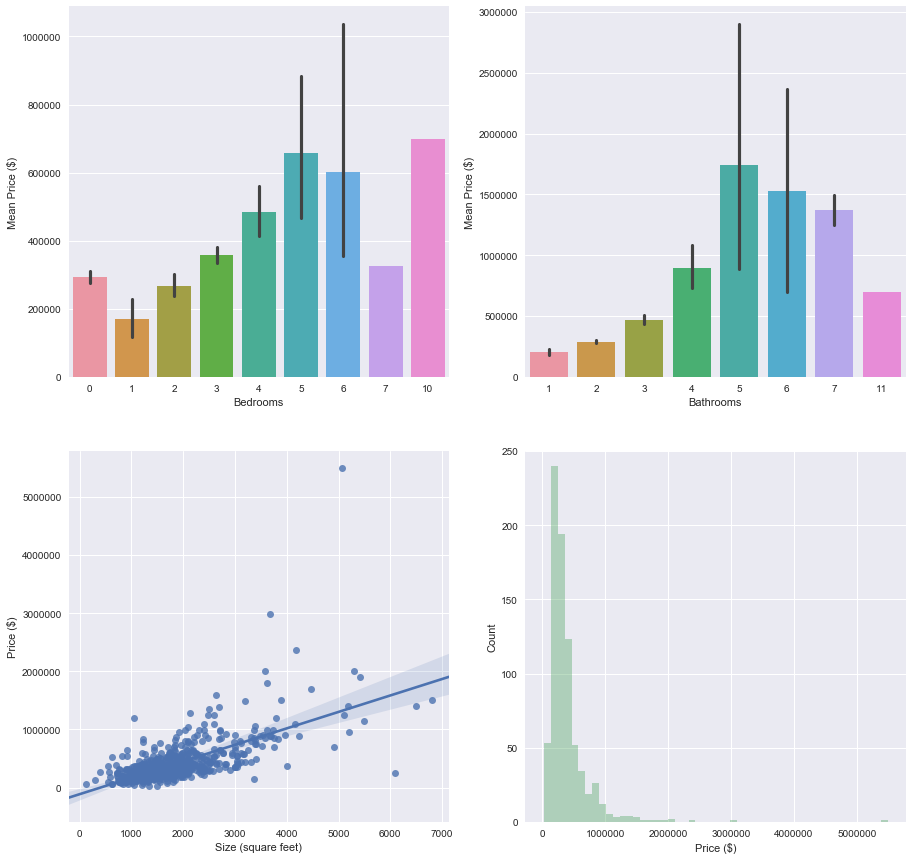

In [14]:
# Define figure/axes
f, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, figsize=(15,15), sharex=False, sharey=False)

# Plot Price vs Number of bedrooms : 
sns.barplot(x='Bedrooms', y='Price', data=data, ax=ax1)
ax1.set_ylabel('Mean Price ($)')

# Plot Price vs Number Bathrooms
sns.barplot(x='Bathrooms', y='Price', data=data, ax=ax2)
ax2.set_ylabel('Mean Price ($)')

# Plot Price vs Size
sns.regplot(x='Size', y='Price', data=data, ax=ax3)
ax3.set_xlabel('Size (square feet)')
ax3.set_ylabel('Price ($)')

# Plot price distribution
sns.distplot(data.Price.values, kde=False, ax=ax4)
ax4.set_ybound(0, 250) # Was not doing this automatically for some reason
ax4.set_ylabel('Count')
ax4.set_xlabel('Price ($)')

From these plots, we can see a few things already.  First of all, looking at the price distribution, there is one that goes over 5 Million dollars.  Thise will not be representative of the data, and does not have any outstanding features (from this data set anyways).  It is probably best not to include it since it will certainly throw off our model.  There is also one that is around 3M dollars, which is pretty far from the tail of the distribution.  We will be getting rid of both of these houses, and replot to get a clearer picture.

In [15]:
# Print rows to double check that they have no outstanding features (besides price)
data[data.Price > 2500000]

,MLS,Location,Price,Bedrooms,Bathrooms,Size,Price/SQ.Ft,Status_Foreclosure,Status_Regular,Status_Short Sale
727,154491,Cambria,2995000.0,5,4,3684,812.98,0,1,0
753,154526,Arroyo Grande,5499000.0,4,5,5060,1086.76,0,1,0


In [16]:
# Drop these rows 
data.drop([727, 753], inplace=True)

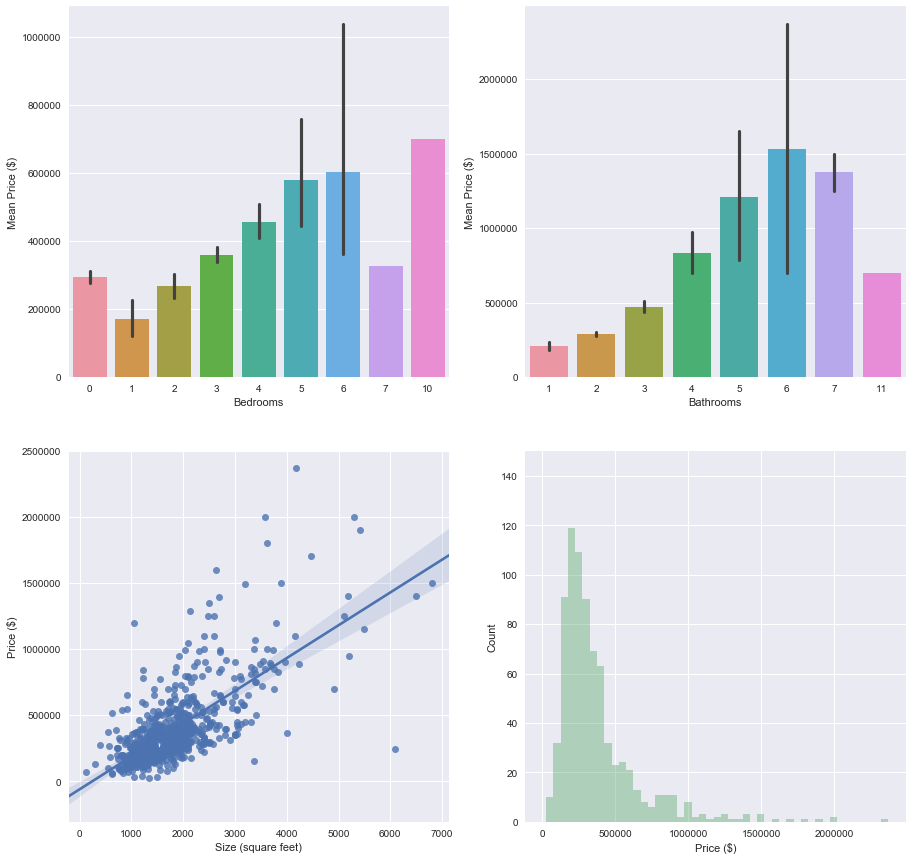

In [17]:
# Replot data for better picture

# Define figure/axes
f, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, figsize=(15,15), sharex=False, sharey=False)

# Plot Price vs Number of bedrooms : 
sns.barplot(x='Bedrooms', y='Price', data=data, ax=ax1)
ax1.set_ylabel('Mean Price ($)')

# Plot Price vs Number Bathrooms
sns.barplot(x='Bathrooms', y='Price', data=data, ax=ax2)
ax2.set_ylabel('Mean Price ($)')

# Plot Price vs Size
sns.regplot(x='Size', y='Price', data=data, ax=ax3)
ax3.set_xlabel('Size (square feet)')
ax3.set_ylabel('Price ($)')

# Plot price distribution
sns.distplot(data.Price.values, kde=False, ax=ax4)
ax4.set_ybound(0, 150) # Was not doing this automatically for some reason
ax4.set_ylabel('Count')
ax4.set_xlabel('Price ($)')

One remarkable thing, that I do not seem to understand is how the mean price takes a dip when there are 7 bathrooms, and how it dips after 6 bedrooms.  Since this isn't a very large dataset, let's take a closer look. 

In [18]:
# Houses with more that 6 bathroom (and lower selling price)
data[data.Bathrooms > 6]

,MLS,Location,Price,Bedrooms,Bathrooms,Size,Price/SQ.Ft,Status_Foreclosure,Status_Regular,Status_Short Sale
201,150143,Arroyo Grande,1499000.0,5,7,6800,220.44,0,0,1
443,152999,Los Osos,1249000.0,6,7,5103,244.76,1,0,0
639,154359,Atascadero,699000.0,10,11,4905,142.51,0,0,1


There are only three houses with more than 6 bathrooms, one is a short sale (sold less than its value), and the other tow were foreclosing.  With only 3 data points, and unusual circumstances, the dip in the average price makes sense.  Now let's look at the house with more than 7 bedrooms, to see if we can explain that dip :  

In [19]:
data[data.Bedrooms == 7]

,MLS,Location,Price,Bedrooms,Bathrooms,Size,Price/SQ.Ft,Status_Foreclosure,Status_Regular,Status_Short Sale
75,145471,Nipomo,325000.0,7,5,2688,120.91,0,0,1


Again, this houses was sold with unusual circumstances, so we can justify the drop in price.

### Location and Population Density

Before making a model, I would like to take a quick look at mean price based on location and population density to show a simple groupby call, and justify scraping the data.  Now I expect the Price / square foot to have more of a correlation with the population density than the total price of the house, so I will be including it in the new data frame. 

In [20]:
location_data = data.groupby('Location', as_index=False).mean()[['Location', 'Price', 'Price/SQ.Ft']]
location_data = location_data.merge(density_data, how='left', on='Location')
location_data.head()

,Location,Price,Price/SQ.Ft,pop_density
0,Arroyo Grande,5.565423e+05,279.213590,3102.52
1,Atascadero,4.365415e+05,221.587353,1162.74
2,Avila Beach,1.205667e+06,566.550000,NaN
3,Bakersfield,9.150000e+04,69.690000,2516.01
4,Bradley,6.857250e+05,276.622500,NaN


Now that we have this data, let us take a look at how Price and Price/SQ.Ft correlate with population density.

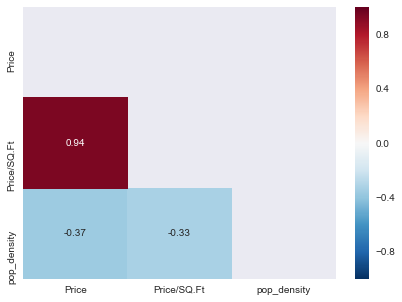

In [21]:
# Show correlation matrix/heatmap
corr_map(location_data, figsize=(7,5))

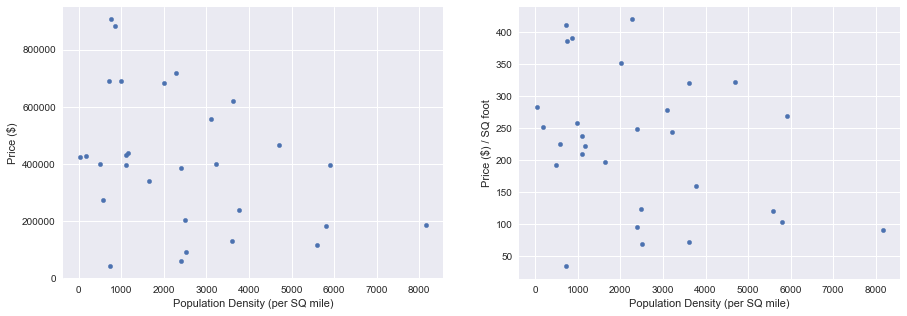

In [22]:
# Plot Price and Price/SQ.Ft as a function of population density
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5));


location_data.plot(x='pop_density', y='Price', ax=ax1, kind='scatter')
ax1.set_xlabel('Population Density (per SQ mile)')
ax1.set_ylabel('Price ($)')

location_data.plot(x='pop_density', y='Price/SQ.Ft', ax=ax2, kind='scatter')
ax2.set_xlabel('Population Density (per SQ mile)')
ax2.set_ylabel('Price ($) / SQ foot')

Well this is surprising.  It seems that there is very little correlation between the two.  I suppose I was wrong to assume as much.  In fact they both seem to be negatively correlated... I thought there may be a mistake in the numbers that I fetched, but that does not seem to be the case.  I guess population density is not a good predictor of housing prices. 

## Building a Model to Predict Prices : 

Now that we have done a little EDA, let us build a model and see if we can correctly predict house prices, based on the given features.  Note that we will no longer be using population density, since it is not a good predictor, and since it's by town, it is effectively the same thing as using the location. 
<br>
<br>
There are many different models that we could use, but I will not be testing many out.  I will simply pick a random forest regressor (because they are my favorite), and see what we get.  Also, we will only do very little grid searching, and hyperparameter optimization. 

### Preprocessing
Since we are using a decision tree method, we do not need to standarize the data, we do however have to encode the location.  We did not do this before since I wanted to use it for the groupby.  

In [23]:
# Encode Location Data
data = pd.get_dummies(data, prefix=None, columns=['Location'])
data.head()

,MLS,Price,Bedrooms,Bathrooms,Size,Price/SQ.Ft,Status_Foreclosure,Status_Regular,Status_Short Sale,Location_Arroyo Grande,...,Location_Pismo Beach,Location_San Luis Obispo,Location_San Miguel,Location_San Simeon,Location_Santa Margarita,Location_Santa Maria-Orcutt,Location_Santa Ynez,Location_Soledad,Location_Solvang,Location_Templeton
0,132842,795000.0,3,3,2371,335.30,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,134364,399000.0,4,3,2818,141.59,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,135141,545000.0,4,3,3032,179.75,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,135712,909000.0,4,4,3540,256.78,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,136282,109900.0,3,1,1249,87.99,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [24]:
# Seperate Data into predictors and target variable (X, y)
X = data[[c for c in data.columns if c != 'Price']].values
y = data.Price.values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

With the data split into a training and testing set, we can now make our model.  For this we will be using a grid search to find the best hyperparameters.

In [25]:
# Define Grid parameters to loop over. 
grid_params = {
    'n_estimators'     : [5, 10, 20, 30], # Number of Trees
    'max_depth'        : [None, 2, 4, 8], # Maximum number of splits in a branch
    'min_samples_split' : [2, 4, 8]       # Minimum number of rows that have to be in node. 
}

# Define and fit grid / random forest regressor
M = GridSearchCV(RandomForestRegressor(), param_grid=grid_params, n_jobs=-1)
M.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 20, 30], 'max_depth': [None, 2, 4, 8], 'min_samples_split': [2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Before looking at how our model performed, lets look at the best parameters out of curiosity : 

In [26]:
M.best_params_

{'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 30}

Since this is a demonstration, we will not be fine tuning any further.  So without further ado, let us look at the results : 

In [27]:
print('Training Set Score (R2): ', M.score(X_train, y_train))
print('Testing Set Score (R2) :', M.score(X_test, y_test))

Training Set Score (R2):  0.993778836143
Testing Set Score (R2) : 0.971809855938


With an R2 value of 0.97 on the testing set, I would say this is a pretty good model!  For the sake of completion, let's plot predictted vs actual values : 

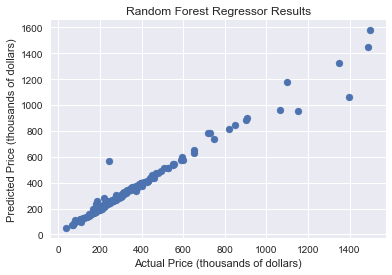

In [28]:
predictions = M.predict(X_test)

plt.scatter(x=y_test/1000, y=predictions/1000)
plt.xlabel('Actual Price (thousands of dollars)')
plt.ylabel('Predicted Price (thousands of dollars)')
plt.title('Random Forest Regressor Results')

## Model Conclusion : 
We have used a small data set of houses in San Luis Obipso, California area and built a model to estimate prices based on features such as : size, number of bathrooms, etc... 
We have found that we can accurately predict with an R2 score of 0.97, which is very good. That being said, this is a demonstration, and  I am sure we could make this better with some more fine tuning, and perhaps other types of models would work better.
<br>
<br>
### Usage for HomeTap : 
With accurate estimates based on property features, we can use a model such as this to get the present value of a house.  If combined with timeseries data of housing in a specific area, we can predict its future value, and hence the profits from investing in shares of a house, hence being able to make an informed decision on whether one should invest in the first place. 
<br><br>
### Final Thoughts : 
I admit that actual data used on the job is probably messier than this, has more features, would need more cleaning / preprocessing.  I am also only speculating the details of the business plan.  But, again, this was mostly to give a quick demonstration of my skills, and show my interest in the position.  I hope you have enjoyed going through it!